# Allan Variance Measurement

The script implements measurement of Allan Deviation and is related to the following blog post https://www.zhinst.com/europe/en/node/3219/edit. 

Copyright (C) 2023 Zurich Instruments

In [1]:
# Import libraries

#from __future__ import print_function
import numpy as np
from zhinst.toolkit import Session
import os
import allantools
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime
import time
import os
import pickle
from matplotlib import font_manager
from itertools import chain


## Connect to the Zurich Instruments lock-in amplifer

In [2]:
device_id = 'dev4745'
server_host='localhost'
session = Session(server_host)
device = session.connect_device(device_id)

# Define all the measurement parameters of the Lock-in

In [3]:
#define initial parameters

amplitude=0.1
rangeamp=1
out_channel = 0
out_mixer_channel = 0
in_channel = 0
demod_index = 0
osc_index = 0
time_constant = 5e-5
filterorder=4
frequency =  1.84410200e6
rate=1/(4*2*time_constant)


with device.set_transaction():
    device.sigins[in_channel].ac(0)
    device.sigins[in_channel].diff(0)
    device.sigins[in_channel].imp50(0)
    device.sigins[in_channel].range(1)
    device.demods[demod_index].enable(1)
    device.demods[demod_index].adcselect(in_channel)
    device.demods[demod_index].order(filterorder)
    device.demods[demod_index].oscselect(osc_index)
    device.demods[demod_index].timeconstant(time_constant)
    device.demods[demod_index].rate(rate)
    device.demods[demod_index].harmonic(1)
    device.sigouts[out_mixer_channel].enables[0](1)
    device.sigouts[out_channel].on(1)
    device.sigouts[out_channel].range(rangeamp)
    device.oscs[osc_index].freq(frequency)
    

## Poll the data to start the measurements

In the next section the node is polled and the data is dumped in a temporary file to save memory allocations. For longer measurements its always advised to dump files in a temporary location rather than saving on to a single string.

In [4]:
time_meas= 3 #Define the total measurement time in [s]

def L1_SimplePoll(device_id, demod_index):

    # subscribe to the demodulator poll node
    poll_node=device.demods[demod_index].sample
    poll_node.subscribe()
    
    # Poll the subscribed data from the data server. Poll will block and record
    # for poll_length seconds.
    total_length = time_meas # [s] # It will have to looped for the measurement
    poll_length = 1 # [s] # Poll length cannot be more than 5s
    poll_timeout = 0.1  # [ms]
    poll_flags = 0
    poll_return_flat_dict = True

    numbofPolls = int(np.ceil(total_length/poll_length))

    #data_i = []
    ij=1
    for i_poll in range(numbofPolls):        
        data_i= session.poll(recording_time=poll_length, timeout=poll_timeout)        
        data_i_poll = data_i[poll_node]
        #data_i.append(data_i_poll)
        file = open("file_%s.dat" % ij,'wb')
        #print(ij)
        ij=ij+1
        pickle.dump(data_i_poll, file)
        file.close()

   
    # get instrument's clockbase  
    timebase = device.system.properties.timebase()

    device.unsubscribe()

    #return(data_i,clockbase)
    return(timebase)

#Function to convert timestamp to real time

def timestamp_to_elapstime(timestamp, timebase):
    timestamp = timestamp - timestamp[0]
    elapstime = timestamp*timebase
    return(elapstime)

## Call the SimplePoll function to aquire

In [5]:
# call the function to poll the data
#Data['raw'],clockbase = L1_SimplePoll(device_id',apilevel,demod_index)
timebase=L1_SimplePoll(device_id, demod_index)

print('Aquisition Complete')

Aquisition Complete


# Combine the data into a single file

From the polled data we extract the relevant information. In this case the informations are the quadratures, frequencies and timestamps. End of the sectio the timestamps are converted into real time using the clockbase.

In [6]:
now = datetime.date.today()  
ij=1

# Prepare the Data structure array to write the data

Data = {'frequency':[],'x':[],'y':[], 'elapsedtime':[]}

for ii in range(time_meas):
    #print(ij)
    file=open("file_%s.dat" % ij,'rb')
    data_i_poll = pickle.load(file)
    Data['elapsedtime'].append(data_i_poll['timestamp'])
    Data['frequency'].append(data_i_poll['frequency'])
    Data['x'].append(data_i_poll['x'])
    Data['y'].append(data_i_poll['y'])
    file.close()
    ij=ij+1

    
Data['elapsedtime']=np.array(list(chain.from_iterable(Data['elapsedtime'])))
Data['x']=np.array(list(chain.from_iterable(Data['x'])))
Data['y']=np.array(list(chain.from_iterable(Data['y'])))
Data['frequency']=np.array(list(chain.from_iterable(Data['frequency'])))

Data['elapsedtime'] = timestamp_to_elapstime(Data['elapsedtime'] , timebase)
time0=Data['elapsedtime'][1]

# Plot the data

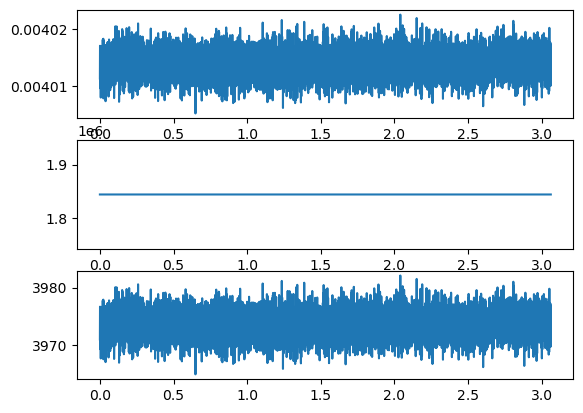

In [7]:
# using a subplot structure for the plot

plt.subplot(3,1,1)
plt.plot(Data['elapsedtime'],np.arctan(Data['y'],Data['x']))
plt.subplot(3,1,2)
plt.plot(Data['elapsedtime'],Data['frequency'])
plt.subplot(3,1,3)
plt.plot(Data['elapsedtime'],np.sqrt(Data['x']**2+Data['y']**2)*0.7e6)
plt.show()

# Calculate sampling rate 

rate = Data['elapsedtime'][1:-1]-Data['elapsedtime'][0:-2] # not sure whats happening here
rate = np.round(1/rate[0]) #[Hz]   
Data['rate'] = rate

# Compute overlapping Allan Deviation 

In [8]:
# Calculate Allan variance (ad is squared)

print('started to compute Allan variance')
taus = np.logspace(-1,time_meas,10000)
Data['phase']=np.arctan(Data['y'],Data['x'])

AllanFunction = 'allantools.oadev'   
(t2, ad, ade, adn) = allantools.oadev(Data['phase'],
                                      rate=Data['rate'], 
                                      data_type="phase",
                                      taus=taus,
                                      )
                                   

Data[AllanFunction]={'t2':t2,
                     'av':ad**2 ,
                     'ad':ad,                                   
                     'ade':ade,
                     'adn':adn,
                    }

print('fin')

started to compute Allan variance
fin


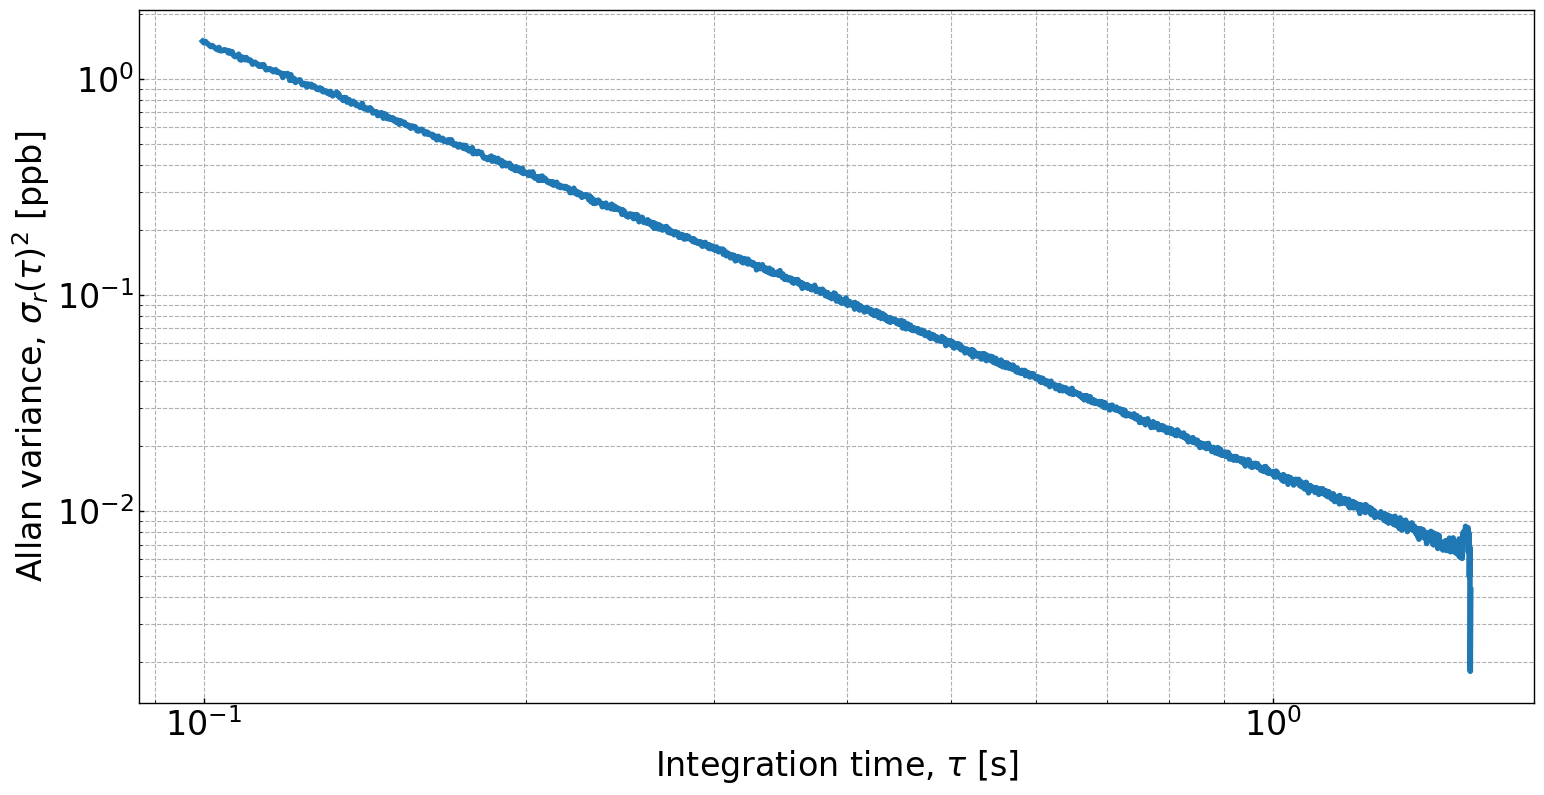

In [9]:
#%% Plot the results
SMALL_SIZE = 24
MEDIUM_SIZE = 24
BIGGER_SIZE = 24
params = {'font.size': SMALL_SIZE ,
          'axes.linewidth' : 1,
          'axes.titlesize': SMALL_SIZE,
          'axes.labelsize':MEDIUM_SIZE,
          
          "text.usetex": False,

          'legend.fontsize':SMALL_SIZE,
          
          'xtick.major.width' : 1,
          'xtick.labelsize' : SMALL_SIZE,
          'xtick.major.top': True,
          'xtick.minor.top': True,      
          'xtick.direction' :'in',
          
          'ytick.major.width': 1,
          'ytick.labelsize' : SMALL_SIZE,
          'ytick.major.right': True,
          'ytick.minor.right': True,
          'ytick.direction' :'in',
          
          'savefig.format' :'png',
          # 'figure.figsize' :(5,8.27)
          }
mpl.rcParams.update(params)

fig = plt.figure(figsize=[18,9]) 
ax = plt.axes()
ax.plot(Data[AllanFunction]['t2'],
        Data[AllanFunction]['av']*1e9,
        linewidth = 4,
        ) 
    

ax.set_xscale("log")
ax.set_yscale("log")
#ax.legend()
ax.set_xlabel(r'Integration time, $\tau$ [s]')
ax.set_ylabel(r'Allan variance, $\sigma_r(\tau)^2$ [ppb]')
ax.axes.grid(which='both',
             linestyle = '--' )
ax.axes.tick_params(which='both')
#ax.set_title('Frequency stability, 17 kHz, PLL bandwidth ~ 300 Hz')
          
plt.show()

